# <ins>APPRENTISSAGE DES IMAGES AVEC EFFICIENTNETB1 APRES PRETRAITEMENT</ins>

## <ins>CHARGEMENT DES LIBRAIRIES</ins>

In [1]:
import numpy as np
import pandas as pd
import json
import math
from glob import glob
import pathlib
import os

import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import h5py

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-04 20:57:47.409170: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 20:57:48.642377: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <ins>CHARGEMENT DE NOTRE DATAFRAME APRES PREPROCESSING</ins>

In [2]:
df = pd.read_csv('df_preprocess.csv', index_col=[0])
df.prdtypecode = df.prdtypecode.astype(str)
df.filepath = df.filepath.astype(str)
df.filepath = df.filepath.str.replace('/train/', '/pretraitement/train/')
df.head()

,prdtypecode,filepath,produit_clean
1,2280,./images/pretraitement/train/image_1008141237_...,journal art 2001 art marche salon art asiatiqu...
2,50,./images/pretraitement/train/image_938777978_p...,grand stylet ergonomique bleu gamepad nintendo...
3,1280,./images/pretraitement/train/image_457047496_p...,peluche donald europe disneyland 2000 marionne...
4,2705,./images/pretraitement/train/image_1077757786_...,guerre tuques luc idées grandeur veut organise...
5,2280,./images/pretraitement/train/image_393356830_p...,afrique contemporaine hiver 2004 dossier japon...


## <ins>TRAIN TEST SPLIT</ins>

In [3]:
df_train, df_test = train_test_split(df, test_size = 0.25, random_state = 55)

In [4]:
print("df_train :", df_train.shape)
print("df_test :", df_test.shape)

df_train : (57104, 3)
df_test : (19035, 3)


In [5]:
df_train.to_csv('train_df.csv')
df_test.to_csv('test_df.csv')

In [2]:
df_train = pd.read_csv('train_df.csv', index_col=[0])
df_train.prdtypecode = df_train.prdtypecode.astype(str)
df_test = pd.read_csv('test_df.csv', index_col=[0])
df_test.prdtypecode = df_test.prdtypecode.astype(str)

## <ins>GENERATEUR DE DONNEES</ins>

Les transformations appliquées sur notre image seront :

- une fonction de prétraitement du modèle EfficientNet : preprocess_input.
- création d'un dataset de validation de 20% du dataset train
- une rotation aléatoire sur une plage de 10 degrés.
- une translation verticale et horizontale sur une plage de 10% des dimensions de l'images.
- un agrandissement sur une plage 10% de l'image.
- un retournement aléatoire horizontal de l'image.

In [3]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split = 0.15, rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.1, horizontal_flip = True)

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

## <ins>CREATION DE NOS 3 DATASETS IMAGEDATAGENERATOR</ins>

#### <ins>ITERATEUR</ins>

Cette méthode permettra de charger les images, de générér pour chaque iteration des lots de données (batchs) transformé par le générateur d'images.

In [4]:
BATCH_SIZE = 20

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (224,224),
    batch_size= BATCH_SIZE,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'training'
    )

validation_generator = train_data_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (224,224),
    batch_size= BATCH_SIZE,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'validation'
    )

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (224,224),
    batch_size= 1,
    class_mode= 'categorical',
    shuffle = False, 
    )

Found 48539 validated image filenames belonging to 27 classes.
Found 8565 validated image filenames belonging to 27 classes.
Found 19035 validated image filenames belonging to 27 classes.


##  <ins>CREATION DE NOTRE MODELE EFFICIENTNETB1 AVEC 7 COUCHES SUPPLEMENTAIRES</ins>

Le fait de mettre include_top = False equivaut à geler le poids des couches supérieurs  

In [8]:
base_model = tf.keras.applications.EfficientNetB1(input_shape = (224,224,3), include_top = False, weights = 'imagenet')

inp = Input(shape= (224,224,3))
x = base_model(inp)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.BatchNormalization(trainable = True,axis=1)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization(trainable = True, axis=1)(x)
outputs = tf.keras.layers.Dense(27, activation="softmax")(x)

model = Model(inputs = inp, outputs = outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb1 (Functional)     │ (None, 7, 7, 1280)     │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,431,778 (32.16 MB)

 Trainable params: 8,366,651 (31.92 MB)

 Non-trainable params: 65,127 (254.41 KB)

## <ins>COMPILATION - FONCTION PERTE SPARSE CATEGORIAL CROSSENTROPY - OPTIMIZER ADAM</ins>

In [8]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## <ins>DERNIERES PREPARATION - CALLBACKS</ins>

In [9]:

save_best_models_path = "./sauvegarde_modele/effnetB1_freeze_no_cropped/modele_callback.weights.h5"

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
                    
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_best_models_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')
                     
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,  mode='min')

# Entrainement

callbacks = [model_checkpoint, reduce_lr, earlystopping]

## <ins>FIT DU MODELE EFFICIENTNETB1</ins>

Nous partageons le jeu de données dataset_train entre l'entraînement et la validation, en utilisant les proportions 80% / 20%. Les variables steps_per_epoch et validation_steps servent à calculer le nombre exact d'itérations pour chaque phase durant chaque époque. Gardez en tête que dans ce cas, les mêmes échantillons seront utilisés aussi bien pour l'entraînement que pour la validation, ce qui pourrait introduire un biais si les deux phases étaient fortement corrélées. Mais dans la majorité des cas, cela n'engendrera pas de problème significatif.

In [10]:
# Fit le modèle avec les callbacks spécifiés
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714598447.307249    4117 service.cc:145] XLA service 0x7f13240e8710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714598447.307298    4117 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-01 21:20:48.459290: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-01 21:20:51.846188: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:171

 811/2427 ━━━━━━━━━━━━━━━━━━━━ 5:49 217ms/step - accuracy: 0.2804 - loss: 2.7948

I0000 00:00:1714598740.311428    4311 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30235', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1714598741.228864    4311 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30237', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1714598741.305076    4307 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30237', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1714598741.568959    4303 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30237', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1714598741.758439    4312 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_29249', 260 bytes spill stores, 260 bytes spill loads



2427/2427 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.3430 - loss: 2.4381

I0000 00:00:1714599252.997511    4449 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2919', 20 bytes spill stores, 20 bytes spill loads



2427/2427 ━━━━━━━━━━━━━━━━━━━━ 847s 297ms/step - accuracy: 0.3430 - loss: 2.4380 - val_accuracy: 0.4442 - val_loss: 2.0078 - learning_rate: 0.0010
Epoch 2/10
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 584s 240ms/step - accuracy: 0.4693 - loss: 1.8470 - val_accuracy: 0.4894 - val_loss: 1.8263 - learning_rate: 0.0010
Epoch 3/10
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 594s 244ms/step - accuracy: 0.5071 - loss: 1.6769 - val_accuracy: 0.5281 - val_loss: 1.6429 - learning_rate: 0.0010
Epoch 4/10
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 585s 240ms/step - accuracy: 0.5366 - loss: 1.5584 - val_accuracy: 0.5429 - val_loss: 1.5791 - learning_rate: 0.0010
Epoch 5/10
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 582s 239ms/step - accuracy: 0.5594 - loss: 1.4709 - val_accuracy: 0.5398 - val_loss: 1.6362 - learning_rate: 0.0010
Epoch 6/10
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 588s 242ms/step - accuracy: 0.5863 - loss: 1.3780 - val_accuracy: 0.4813 - val_loss: 1.7926 - learning_rate: 0.0010
Epoch 7/10
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 592s 243ms/step - acc

## <ins>SAUVEGARDE DE NOTRE MODELLE</ins>

In [11]:
# Chemin pour enregistrer le modèle
model_path = './sauvegarde_modele/effnetB1_freeze_no_cropped/effnetB1_freeze_no_cropped.keras'

# Enregistrement du modèle
model.save(model_path)

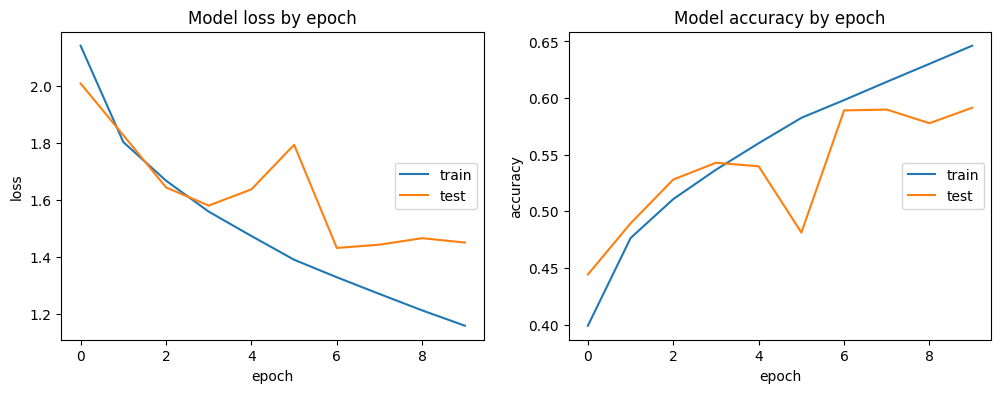

In [12]:

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [13]:
# Probabilités renvoyées par le modèle
y_prob = model.predict(test_generator, batch_size=1)

# Prédiction de la classe
y_pred = tf.argmax(y_prob, axis=-1).numpy()

19035/19035 ━━━━━━━━━━━━━━━━━━━━ 212s 11ms/step


In [17]:
# Vraies étiquettes
y_test = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [25]:
# Classification report
from sklearn.metrics import classification_report, accuracy_score, f1_score

print(classification_report(y_test, y_pred, target_names = class_labels))

print ("accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

          10       0.46      0.73      0.57       649
        1140       0.46      0.65      0.54       509
        1160       0.91      0.88      0.90       691
        1180       0.30      0.24      0.27       148
        1280       0.44      0.35      0.39      1105
        1281       0.32      0.32      0.32       499
        1300       0.61      0.64      0.63      1176
        1301       0.48      0.47      0.47       159
        1302       0.39      0.32      0.35       593
        1320       0.48      0.28      0.35       706
        1560       0.58      0.56      0.57      1298
        1920       0.76      0.82      0.79       988
        1940       0.57      0.37      0.45       172
        2060       0.33      0.63      0.44      1209
        2220       0.40      0.26      0.32       191
        2280       0.68      0.79      0.73       952
        2403       0.72      0.58      0.64       994
        2462       0.54    

In [7]:
# Chargement du modele
# Chargement du modèle EfficientNetB1
model = tf.keras.models.load_model("./sauvegarde_modele/effnetB1_freeze_no_cropped/effnetB1_freeze_no_cropped.keras")
model.compile(model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy']))

2024-05-02 08:35:44.553384: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 08:35:44.580430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 08:35:44.580460: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 08:35:44.583092: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 08:35:44.583117: I external/local_xla/xla/stream_executor

In [10]:

save_best_models_path = "./sauvegarde_modele/effnetB1_unfreeze_no_cropped/modele_callback.weights.h5"

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
                    
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_best_models_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')
                     
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,  mode='min')

# Entrainement

callbacks = [model_checkpoint, reduce_lr, earlystopping]

## <ins>DE-FREEZ DES 8 DERNIERES COUCHES DE NOTRE MODELE EFFICIENTNET</ins>

In [11]:
for layer in base_model.layers[-8:]:
    layer.trainable = True

lr = 0.0001
optimizer = Adam(learning_rate=lr)

# compile avec modification de l'optimizer
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])

# entrainement avec la méthode .fit()
history = model.fit(
    train_generator, 
    epochs = 10,
    validation_data = validation_generator,
    callbacks = callbacks)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714639118.441891    5316 service.cc:145] XLA service 0x7f4810004290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714639118.441999    5316 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-02 08:38:39.640192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-02 08:38:43.115655: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:171

1889/2427 ━━━━━━━━━━━━━━━━━━━━ 1:54 212ms/step - accuracy: 0.2950 - loss: 2.7063

I0000 00:00:1714639634.699019    5564 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_29249', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1714639635.511904    5568 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30235', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1714639635.714663    5560 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30237', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1714639635.791062    5571 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30237', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1714639636.053722    5567 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30237', 32 bytes spill stores, 32 bytes spill loads



2427/2427 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.3157 - loss: 2.6040

I0000 00:00:1714639909.998734    5748 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2919', 20 bytes spill stores, 20 bytes spill loads



2427/2427 ━━━━━━━━━━━━━━━━━━━━ 834s 293ms/step - accuracy: 0.3157 - loss: 2.6039 - val_accuracy: 0.5494 - val_loss: 1.5628 - learning_rate: 1.0000e-04
Epoch 2/10
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 609s 250ms/step - accuracy: 0.5156 - loss: 1.6600 - val_accuracy: 0.5928 - val_loss: 1.3880 - learning_rate: 1.0000e-04
Epoch 3/10
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 612s 252ms/step - accuracy: 0.5756 - loss: 1.4406 - val_accuracy: 0.6148 - val_loss: 1.3230 - learning_rate: 1.0000e-04
Epoch 4/10
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 621s 255ms/step - accuracy: 0.6129 - loss: 1.2807 - val_accuracy: 0.6292 - val_loss: 1.2711 - learning_rate: 1.0000e-04
Epoch 5/10
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 613s 252ms/step - accuracy: 0.6436 - loss: 1.1568 - val_accuracy: 0.6320 - val_loss: 1.2695 - learning_rate: 1.0000e-04
Epoch 6/10
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 820s 337ms/step - accuracy: 0.6740 - loss: 1.0496 - val_accuracy: 0.6460 - val_loss: 1.2585 - learning_rate: 1.0000e-04
Epoch 7/10
2427/2427 ━━━━━━━━━━━━━━━━━━

In [12]:
# Chemin pour enregistrer le modèle
model_path = './sauvegarde_modele/effnetB1_unfreeze_no_cropped/effnetB1_unfreeze_no_cropped.keras'

# Enregistrement du modèle
model.save(model_path)

## <ins>PREDICTIONS ET SCORES</ins>

In [5]:
# Chargement du modèle EfficientNetB1
model = tf.keras.models.load_model("./sauvegarde_modele/effnetB1_unfreeze_no_cropped/effnetB1_unfreeze_no_cropped.keras")
model.compile(model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy']))

2024-05-02 17:22:44.969094: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 17:22:44.976675: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 17:22:44.976710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 17:22:44.979237: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 17:22:44.979264: I external/local_xla/xla/stream_executor

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Recupération des probabilités renvoyés par le modèke pour les 19035 images à 17:23:09


I0000 00:00:1714670592.125761    7732 service.cc:145] XLA service 0x7fb53c003e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714670592.125810    7732 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-02 17:23:12.242672: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-02 17:23:12.828196: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


   20/19035 ━━━━━━━━━━━━━━━━━━━━ 2:43 9ms/step 

I0000 00:00:1714670600.889966    7732 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19035/19035 ━━━━━━━━━━━━━━━━━━━━ 188s 9ms/step
Fin de la récupération à 17:26:24
Délai du modèle pour la prédiction :  0:03:14.977668
ACCURACY DU MODELE :  0.531652219595482

F1_SCORE_WEIGHTED :  0.5374534419646985

              precision    recall  f1-score   support

          10       0.33      0.73      0.46       649
        1140       0.52      0.56      0.54       509
        1160       0.88      0.71      0.79       691
        1180       0.36      0.11      0.17       148
        1280       0.43      0.28      0.34      1105
        1281       0.24      0.31      0.27       499
        1300       0.57      0.62      0.59      1176
        1301       0.23      0.69      0.35       159
        1302       0.31      0.51      0.38       593
        1320       0.47      0.36      0.41       706
        1560       0.62      0.52      0.56      1298
        1920       0.80      0.76      0.78       988
        1940       0.70      0.44      0.54       172
        2060       0.37    

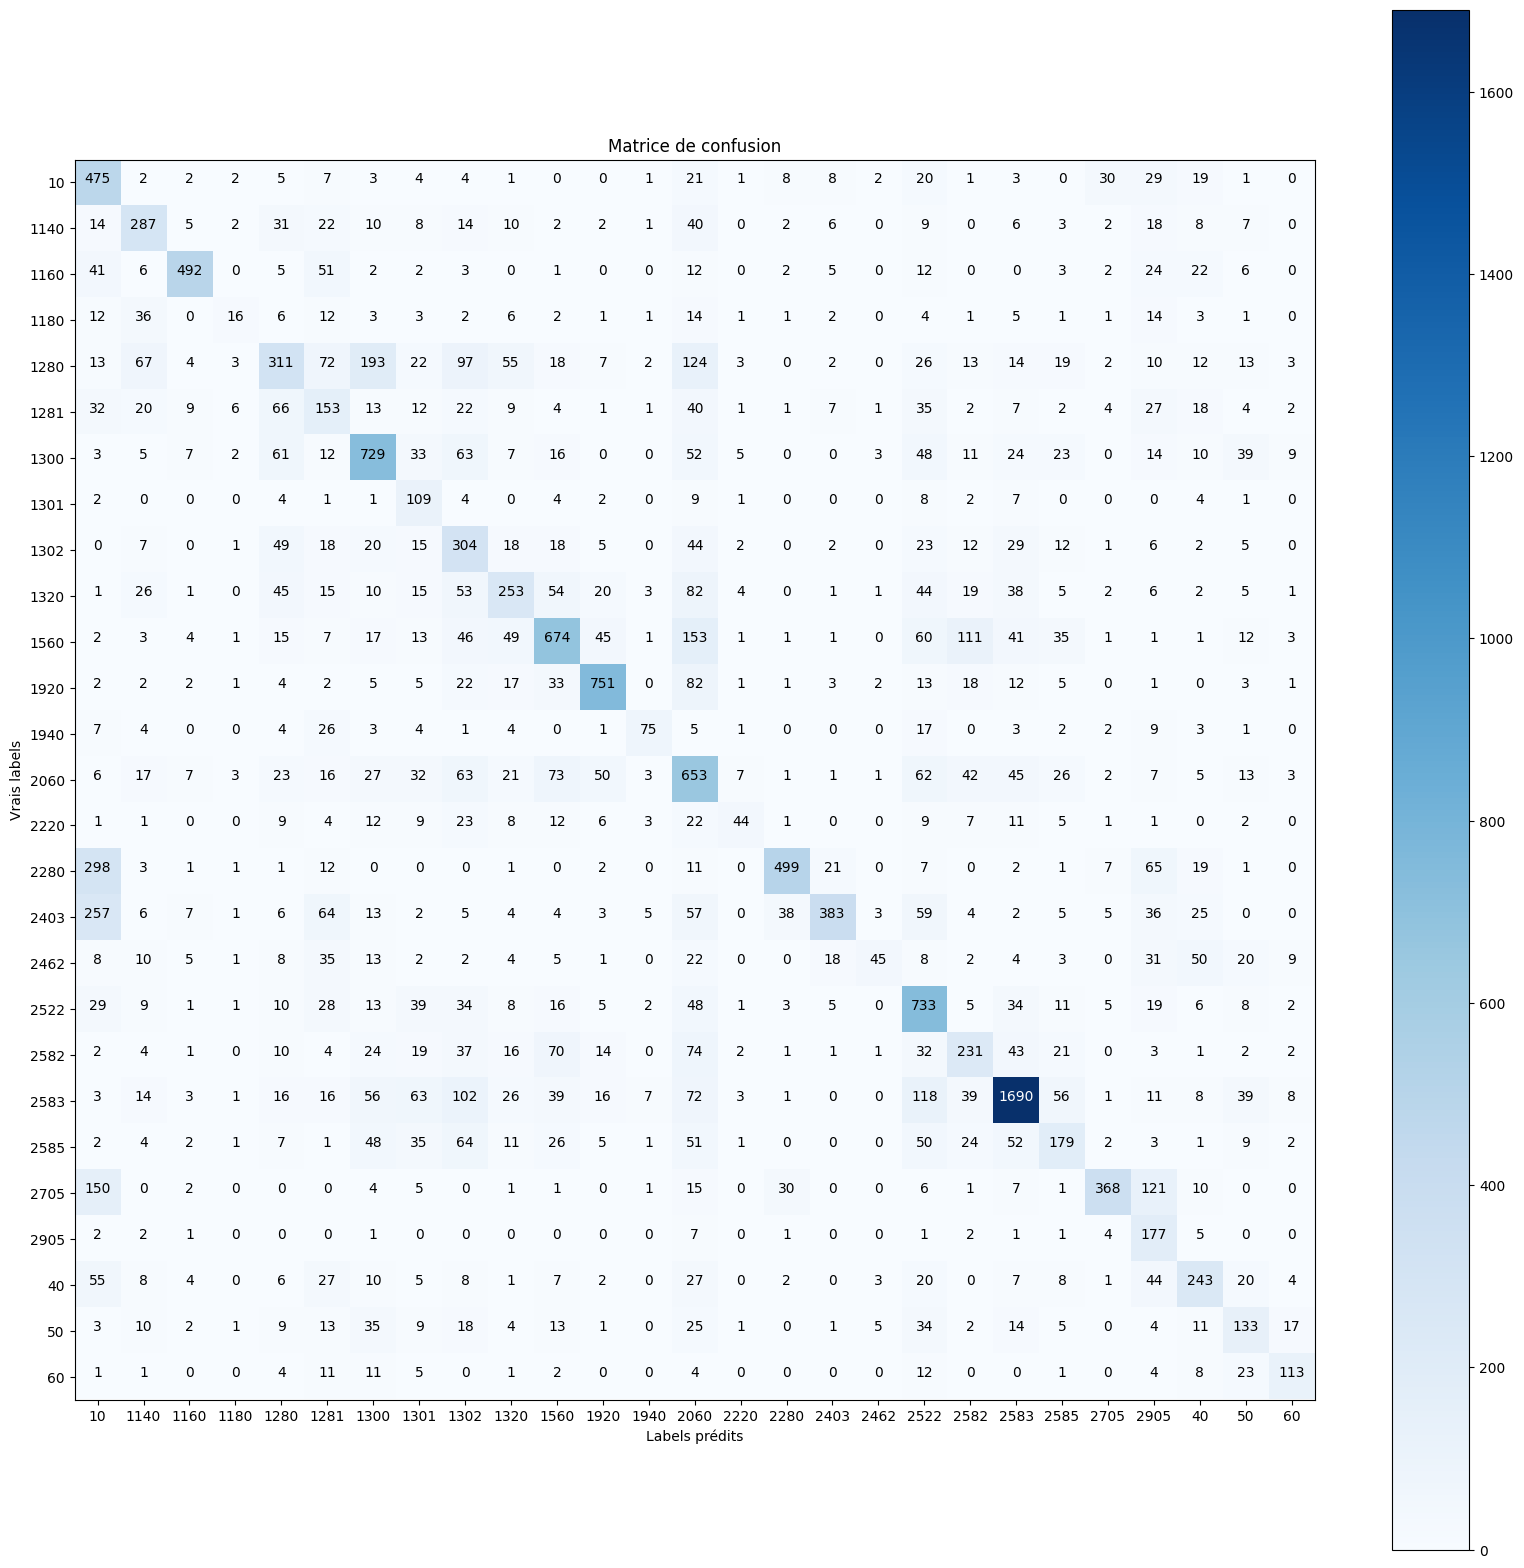

In [6]:
import projet_rakuten

from projet_rakuten import predict

y_prob, y_pred, y_test, class_labels = predict(test_generator, model)